references
1. https://github.com/ultralytics/ultralytics/issues/1693
2. https://discuss.pytorch.org/t/what-is-the-purpose-of-is-leaf/87000/3
3. https://pytorch.org/docs/master/autograd.html?highlight=grad#torch.autograd.grad
4. https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/


In [1]:
from ultralytics import YOLO
from ultralytics.yolo.v8.detect.train import DetectionTrainer
from ultralytics.yolo.data.dataloaders.v5loader import create_dataloader
from ultralytics.yolo.v8.detect.train import Loss
import cv2
import torch
import matplotlib.pyplot as plt
import resize_right
import numpy as np

In [4]:
# load detection trainer using the weights best.pt
# best.pt is the custom model trained on YOLO_data_je
trainer = DetectionTrainer('args_digits_data_ver1.yaml')

Ultralytics YOLOv8.0.86 🚀 Python-3.9.16 torch-2.0.0 CPU
yolo/engine/trainer: task=detect, mode=predict, model=model_results/model_digit_data_ver1_256/weights/best.pt, data=detection_data.yaml, epochs=100, patience=50, batch=32, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=None, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, d

In [5]:
trainer.setup_model()


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

{'epoch': -1,
 'best_fitness': None,
 'model': DetectionModel(
   (model): Sequential(
     (0): Conv(
       (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (1): Conv(
       (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (2): C2f(
       (cv1): Conv(
         (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
         (act): SiLU(inplace=True)
       )
       (cv2): Conv(
         (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track

In [6]:
trainer.set_model_attributes()

## Version using image resizing (without dataloader)

(28, 140, 3)


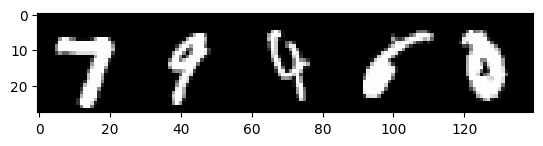

(28, 140, 3)


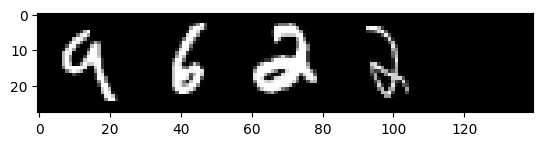

(28, 140, 3)


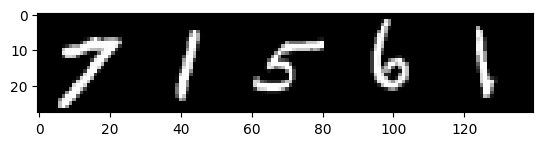

In [50]:
imgs = []
org_img1 = cv2.imread('data/YOLO_data_dg/images/100.png')
org_img2 = cv2.imread('data/YOLO_data_dg/images/101.png')
org_img3 = cv2.imread('data/YOLO_data_dg/images/102.png')

imgs.append(org_img1)
imgs.append(org_img2)
imgs.append(org_img3)

for i in imgs:    
    print(i.shape)
    plt.imshow(i)
    plt.show()

In [56]:
# so that the channel comes first (xdim, ydim, channel) -> (channel, xdim, ydim); threw an error when order different
# error: expected input[1, 128, 128, 3] to have 3 channels, but got 128 channels instead

imgs_ls = []
for img in imgs:
    img = np.moveaxis(img, -1, 0)
    print(img.shape)

#     img = np.expand_dims(img, axis=0)
    # input_img = np.expand_dims(input_img, axis=0)# to add (1,1,)
#     print(img.shape)
    imgs_ls.append(img)
    

(3, 28, 140)
(3, 28, 140)
(3, 28, 140)


In [57]:
batch_imgs = np.stack([imgs_ls[0], imgs_ls[1], imgs_ls[2]])
batch_imgs.shape

(3, 3, 28, 140)

In [58]:
# set requires_grad to be true for the original image (1,3,28,140) before (1,3,128,128)

batch_tensor_img = torch.tensor(np.array(batch_imgs, dtype='float32'), requires_grad=True)
print(batch_tensor_img.shape)

# resize the image for YOLO
batch_tensor_img_resized = resize_right.resize(batch_tensor_img, out_shape=(1,3,256,256))
batch_tensor_img_resized.shape

torch.Size([3, 3, 28, 140])


torch.Size([1, 3, 256, 256])

In [60]:
batch_tensor_img_resized.max()

tensor(226.2613, grad_fn=<MaxBackward1>)

In [72]:
# definining batch with true label and bboxes to calculate the loss

manual_batch = {'ori_shape': ((3, 28, 140),(3, 28, 140),(3, 28, 140),),
 'ratio_pad': None,
 'im_file': None,
 'img': None,
 'cls': torch.tensor([
         [7.],
         [9.],
         [4.],
         [6.],
         [0.],
     
         [9.],
         [6.],
         [2.],
         [2.],
     
         [7.],
         [1.],
         [5.],
         [6.],
         [1.]     
                     ]).reshape(14),
 'bboxes': torch.tensor([
         [0.1, 0.5000, 0.1800, 0.1828],
         [0.3, 0.5000, 0.1800, 0.1828],
         [0.5, 0.5000, 0.1800, 0.1828],
         [0.7, 0.5000, 0.1800, 0.1828],
         [0.9, 0.5000, 0.1800, 0.1828],
     
         [0.1, 0.5000, 0.1800, 0.1828],
         [0.3, 0.5000, 0.1800, 0.1828],
         [0.5, 0.5000, 0.1800, 0.1828],
         [0.7, 0.5000, 0.1800, 0.1828],
     
         [0.1, 0.5000, 0.1800, 0.1828],
         [0.3, 0.5000, 0.1800, 0.1828],
         [0.5, 0.5000, 0.1800, 0.1828],
         [0.7, 0.5000, 0.1800, 0.1828],
         [0.9, 0.5000, 0.1800, 0.1828]
 
 ]),
 'batch_idx': torch.tensor([0., 0., 0., 0., 0.,
                            1., 1., 1., 1.,
                            2., 2., 2., 2.,2.
                           ])}

# resized image we feed to the model
manual_batch['img'] = batch_tensor_img_resized

In [73]:
# this is where backpropagation happens
a = trainer.model(batch_tensor_img_resized)
loss_fn = Loss(trainer.model)
loss, _ = loss_fn(a, manual_batch)
loss.backward()

In [74]:
print(loss)

tensor(10.1577, grad_fn=<MulBackward0>)


In [75]:
print(batch_tensor_img.grad.shape)
batch_tensor_img.grad

torch.Size([3, 3, 28, 140])


tensor([[[[-3.5697e-04, -3.7741e-04, -5.9136e-04,  ..., -2.4119e-04, -5.8052e-05, -9.0032e-05],
          [ 4.3870e-04,  1.2190e-03, -4.4811e-04,  ..., -3.1402e-04, -8.5292e-05,  2.9013e-04],
          [ 2.5474e-04, -6.6406e-04, -2.3958e-04,  ..., -2.9309e-04, -1.1591e-04,  1.0128e-04],
          ...,
          [ 2.2459e-04,  3.5988e-06, -2.5192e-04,  ...,  4.8535e-03,  4.6616e-03, -5.0999e-04],
          [-7.3666e-04,  1.3840e-04,  1.6377e-04,  ..., -7.7783e-04, -1.3065e-03, -5.7398e-04],
          [-7.8675e-04, -8.7196e-04,  2.0164e-04,  ..., -1.9413e-03, -8.8914e-04,  4.6853e-04]],

         [[-8.0313e-04,  1.7034e-04,  6.3831e-04,  ..., -1.7515e-04, -3.1391e-04, -1.8353e-04],
          [-5.4642e-03,  6.3251e-04, -5.8953e-04,  ..., -4.4498e-04,  6.7005e-04,  4.7332e-04],
          [ 3.6782e-03,  1.3759e-03,  2.1492e-04,  ..., -3.7052e-04, -4.1978e-04, -2.4767e-04],
          ...,
          [-7.9789e-04,  6.3668e-04, -9.1782e-04,  ...,  9.3533e-03, -1.0874e-02, -8.0346e-03],
        

## one using loader (ignore)

In [64]:
loader = create_dataloader('./data/YOLO_data_dg/images', imgsz=128,
                           batch_size=32,
                           stride=1)

Scanning data/YOLO_data_dg/labels.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]


In [68]:
batch = next(iter(loader[0]))
batch['img'].shape

torch.Size([32, 3, 128, 128])

In [69]:
batch

{'ori_shape': ((28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140)),
 'ratio_pad': (((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.

In [71]:
print(batch['cls'].shape)
print(batch['bboxes'].shape)
print(batch['batch_idx'].shape)

torch.Size([157, 1])
torch.Size([157, 4])
torch.Size([157])


In [34]:
batch['img'][0].shape

torch.Size([3, 128, 128])

In [23]:
# check if the batch['img'] is a leaf node; if it is .backward() accumulates grad
batch['img']=batch['img'].float()
print(batch['img'].is_leaf)
print(batch['img'].requires_grad)
batch['img'].requires_grad=True # additional argument to get the gradient of the input

True
False


In [24]:
batch['img'].shape

torch.Size([1, 3, 128, 128])

In [25]:
# batch variable set from the loader has cls (true label of the images)
# it reads the data from data=../detection_data.yaml, in args.yaml when calling the trainer
batch

{'ori_shape': ((28, 112),),
 'ratio_pad': (((1.1428571428571428, 1.1428571428571428), (0.0, 48.0)),),
 'im_file': ('../data/YOLO_short/images/0.png',),
 'img': tensor([[[[114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           ...,
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.]],
 
          [[114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           ...,
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.]],
 
          [[114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..

In [26]:
# this is where backpropagation happens
a = trainer.model(batch['img'])
loss_fn = Loss(trainer.model)
loss, _ = loss_fn(a, batch)
loss.backward()

In [27]:
(batch['img'].grad).shape # this version gives the gradient w.r.t. resized input

torch.Size([1, 3, 128, 128])

In [28]:
batch['img'].grad # checked that the gradient w.r.t. input is deterministic

tensor([[[[ 3.0678e-05, -1.8723e-04, -5.6495e-04,  ...,  5.5701e-03,  7.3125e-03,  5.1939e-03],
          [ 8.4913e-04,  4.8150e-05, -1.2031e-03,  ...,  6.1341e-03,  8.8653e-03,  5.9796e-03],
          [ 2.5488e-03,  7.3475e-04, -2.4057e-03,  ...,  5.9311e-03,  5.5987e-03,  3.4876e-03],
          ...,
          [-2.4228e-03, -9.3500e-04, -3.8466e-04,  ..., -5.1462e-03, -6.4833e-03, -4.9381e-03],
          [-4.3758e-03, -4.8144e-03, -3.6602e-03,  ..., -2.9989e-03, -2.8014e-03, -1.9724e-03],
          [-3.9081e-03, -4.6390e-03, -3.2471e-03,  ..., -2.5209e-03, -2.4373e-03, -1.9301e-03]],

         [[ 1.4024e-03,  8.5304e-04,  8.9985e-05,  ..., -1.8474e-03, -2.1638e-03, -2.6164e-03],
          [ 8.8364e-04,  4.5892e-04,  3.4072e-04,  ..., -2.0824e-03, -1.9692e-03, -2.5403e-03],
          [-3.0394e-04, -2.3936e-04,  5.9522e-04,  ..., -1.9198e-03, -1.9524e-03, -2.5911e-03],
          ...,
          [ 1.7990e-03,  1.2644e-03, -4.1133e-05,  ...,  1.7578e-03,  2.2166e-03,  1.9157e-03],
        

In [13]:
# #load the model
# model = YOLO("model_results/train7/weights/best.pt")
# res = model(data)
# # model.train(task='detect', data='../detection_data.yaml',
# #              epochs=1, batch=1, augment=False)